# 宝可梦数据集标注及训练文档

In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

## 数据说明

### 1.样本来源
数据集来源于data文件夹中的图像文件

In [2]:
images_folder_path = 'data'

### 2.标注方式
使用 label-studio 工具对图像进行四分类标注，标签分别为：bulbasaur、squirtle、charmander、pikachu
标注完成后，标签信息被记录在名为 label.csv 的文件中

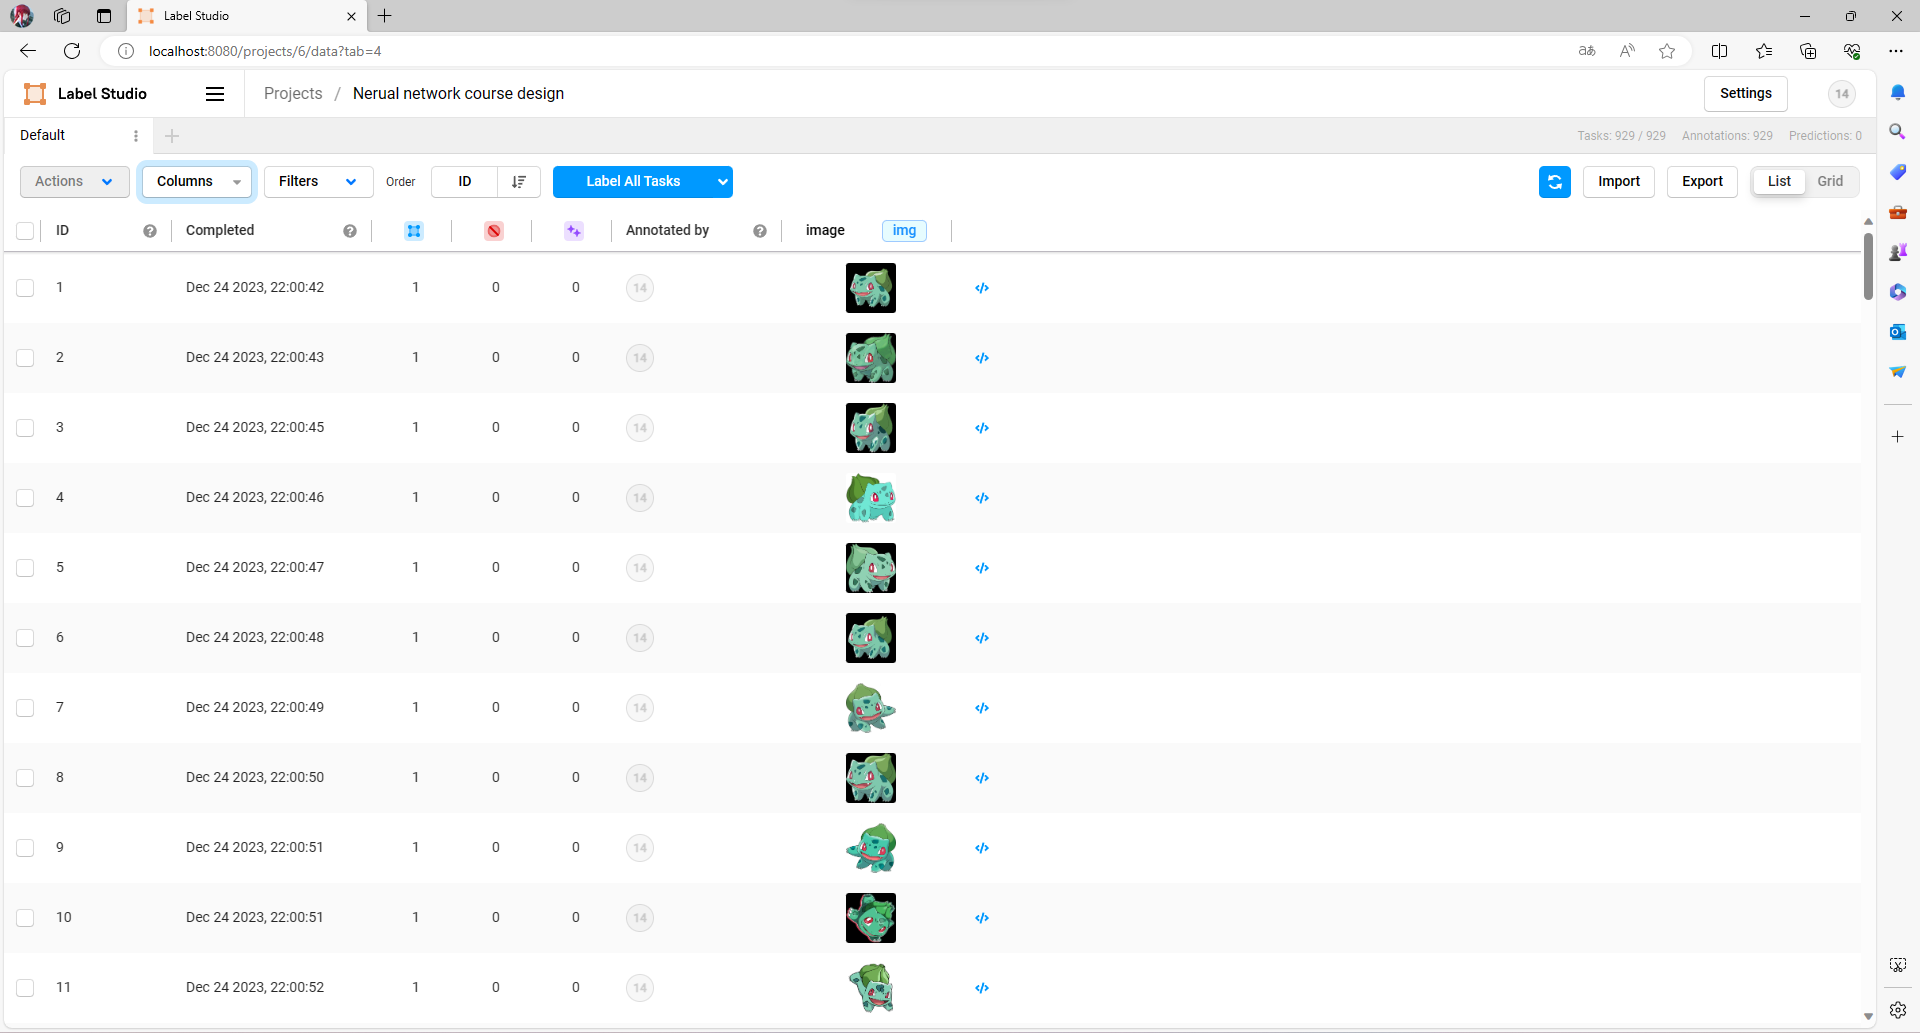

In [3]:
df = pd.read_csv('label.csv')
print(list(set(df['choice'])))
display(df.head())

['charmander', 'bulbasaur', 'squirtle', 'pikachu']


,annotation_id,annotator,choice,created_at,id,image,lead_time,updated_at
0,104,1,bulbasaur,2023-12-24T14:00:42.248986Z,1,/data/upload/6/8a23e605-00000000.jpg,6.421,2023-12-24T14:00:42.248986Z
1,105,1,bulbasaur,2023-12-24T14:00:43.951680Z,2,/data/upload/6/3e22debe-00000001.jpg,1.400,2023-12-24T14:00:43.951855Z
2,106,1,bulbasaur,2023-12-24T14:00:45.097148Z,3,/data/upload/6/e1d26b22-00000002.jpg,0.916,2023-12-24T14:00:45.097148Z
3,107,1,bulbasaur,2023-12-24T14:00:46.399867Z,4,/data/upload/6/d6e252f9-00000003.jpg,1.076,2023-12-24T14:00:46.399867Z
4,108,1,bulbasaur,2023-12-24T14:00:47.260407Z,5,/data/upload/6/d5ada68f-00000004.jpg,0.618,2023-12-24T14:00:47.260407Z


## 网络结构和训练过程

### 1.数据预处理
将图像统一调整为 (299, 299) 大小，并进行归一化处理

In [4]:
# 处理图像和标签
images = []
labels = []
label_map = {'bulbasaur': 0, 'squirtle': 1, 'charmander': 2, 'pikachu': 3}

for index, row in df.iterrows():
    image_name = row['image'].split('-')[-1]
    image_path = os.path.join(images_folder_path, image_name)
    img = Image.open(image_path).resize((299, 299))  # 统一图像大小为 (299, 299)
    img = np.array(img) / 255.0
    images.append(img)
    labels.append(row['choice'])


labels = [label_map[label] for label in labels]
labels = tf.one_hot(labels, depth=len(label_map))

### 2.数据集划分
将数据集分为训练集和测试集，其中测试集占总数据集的 20%

In [5]:
# 将图像和标签转换为数组
images = np.array(images)
labels = np.array(labels)

# 确保图像和标签的数量匹配
assert len(images) == len(labels)

# 数据集划分
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# 转换为 TensorFlow 的 Tensor
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

### 3.迁移学习模型
使用 InceptionV3 网络结构作为基础模型进行迁移学习
修改模型顶部，添加全局平均池化层和全连接层
输出层使用 softmax 激活函数进行四分类预测

In [6]:
# 加载 InceptionV3 模型
base_model = InceptionV3(weights='imagenet', include_top=False)

# 冻结所有层
for layer in base_model.layers:
    layer.trainable = False

# 获取 Mixed5 层的输出
mixed5_output = base_model.get_layer('mixed5').output


# 添加自定义层
x = GlobalAveragePooling2D()(mixed5_output)   
x = Dense(512, activation='relu')(x)
predictions = Dense(len(label_map), activation='softmax')(x)  # 这里的NUM_CLASSES是你任务中的类别数量

# 构建完整的模型
model = Model(inputs=base_model.input, outputs=predictions)

# 查看自定义模型结构
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

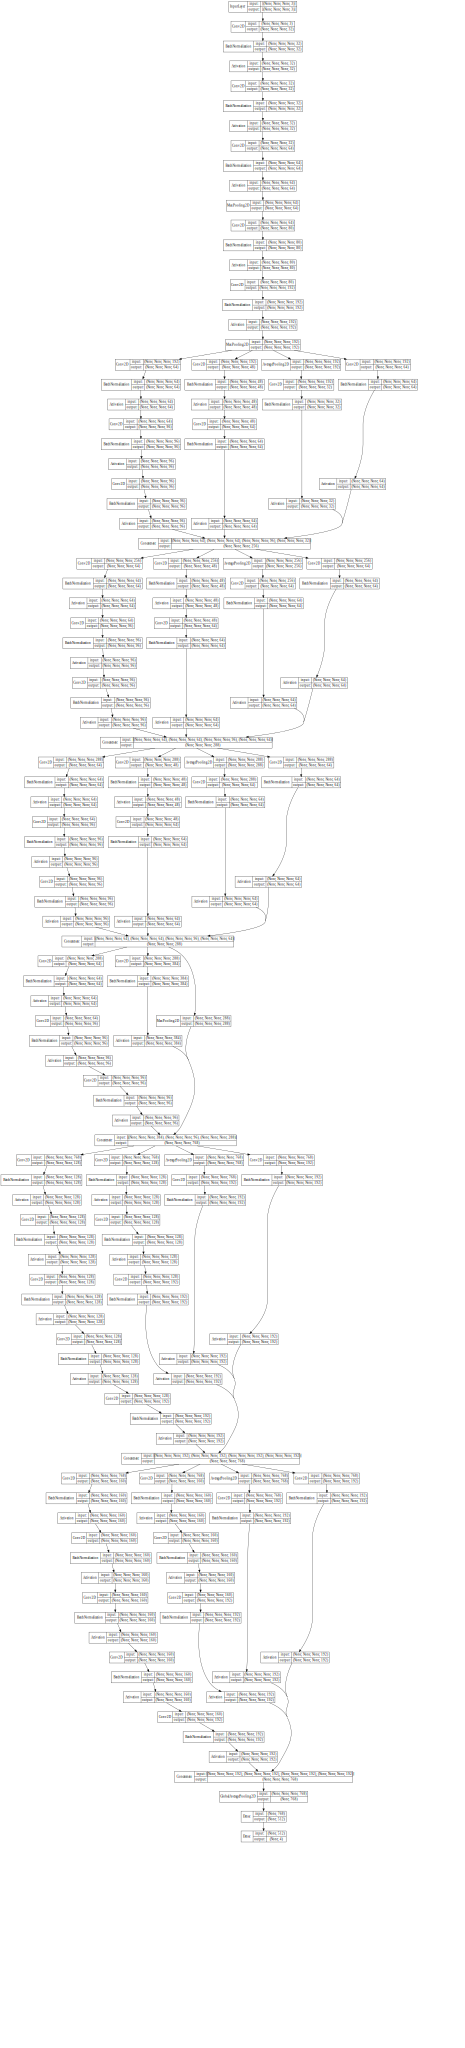

In [7]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, rankdir='TB', dpi=65).create(prog='dot', format='svg'))

In [8]:
len(model.trainable_variables)

4

### 4.模型编译
使用 Adam 优化器，采用 categorical_crossentropy 损失函数进行模型编译

In [9]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=1000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)



initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.0, staircase=True
)


# 在模型编译时设置学习率
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### 5.训练
设定训练周期为 100 次，并记录训练过程中的损失和准确率

In [10]:
num_epochs = 10

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 创建一个保存模型权重的回调函数
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)


history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, callbacks=[cp_callback])

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.2988 - accuracy: 0.3755
Epoch 1: saving model to training_1\cp.ckpt
24/24 [==============================] - 16s 220ms/step - loss: 1.2988 - accuracy: 0.3755 - val_loss: 1.0124 - val_accuracy: 0.5430
Epoch 2/10
23/24 [===========================>..] - ETA: 0s - loss: 0.8663 - accuracy: 0.7188
Epoch 2: saving model to training_1\cp.ckpt
24/24 [==============================] - 4s 168ms/step - loss: 0.8656 - accuracy: 0.7201 - val_loss: 0.7131 - val_accuracy: 0.8333
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.6076 - accuracy: 0.8789
Epoch 3: saving model to training_1\cp.ckpt
24/24 [==============================] - 4s 173ms/step - loss: 0.6076 - accuracy: 0.8789 - val_loss: 0.5551 - val_accuracy: 0.8548
Epoch 4/10
23/24 [===========================>..] - ETA: 0s - loss: 0.4598 - accuracy: 0.8981
Epoch 4: saving model to training_1\cp.ckpt
24/24 [==============================] - 4s 177ms/step

## 测试结果

### 1.模型评估
通过测试集对模型进行评估，得到模型在测试集上的损失和准确率

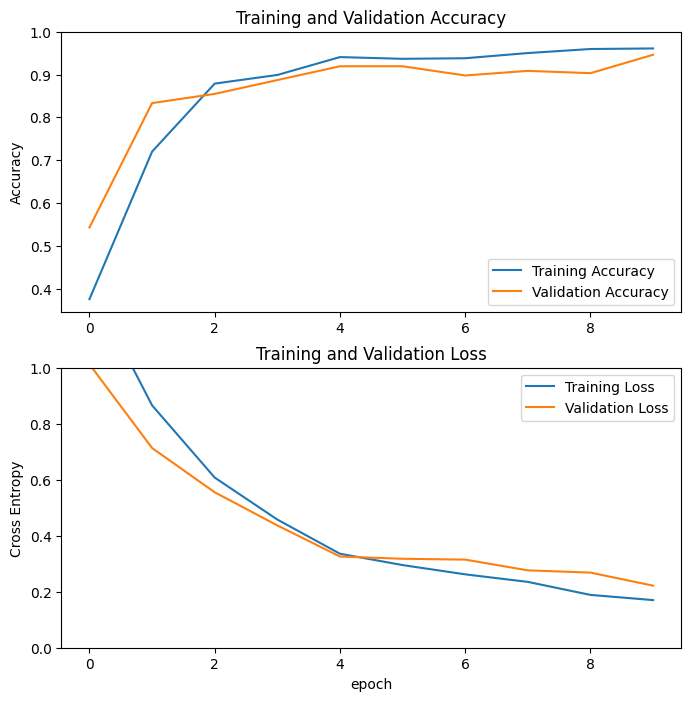

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 2.微调
以较低的学习率，重新调整预训练权重

In [12]:
base_model.trainable = True

In [13]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  168


In [14]:
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [15]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate/100, decay_steps=1000, decay_rate=0.1, staircase=True
)

# 在模型编译时设置学习率
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [17]:
len(model.trainable_variables)

32

In [18]:
num_epochs = 100

checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 创建一个保存模型权重的回调函数
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)


history_fine = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, callbacks=[cp_callback, early_stopping])

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.9017
Epoch 1: saving model to training_2\cp.ckpt
24/24 [==============================] - 11s 250ms/step - loss: 0.2881 - accuracy: 0.9017 - val_loss: 0.2133 - val_accuracy: 0.9355
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9623
Epoch 2: saving model to training_2\cp.ckpt
24/24 [==============================] - 5s 199ms/step - loss: 0.1750 - accuracy: 0.9623 - val_loss: 0.2197 - val_accuracy: 0.9194
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9677
Epoch 3: saving model to training_2\cp.ckpt
24/24 [==============================] - 5s 195ms/step - loss: 0.1413 - accuracy: 0.9677 - val_loss: 0.2187 - val_accuracy: 0.9140
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9798
Epoch 4: saving model to training_2\cp.ckpt
24/24 [==============================] - 5s 194ms/

In [19]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [20]:
initial_epochs = 10

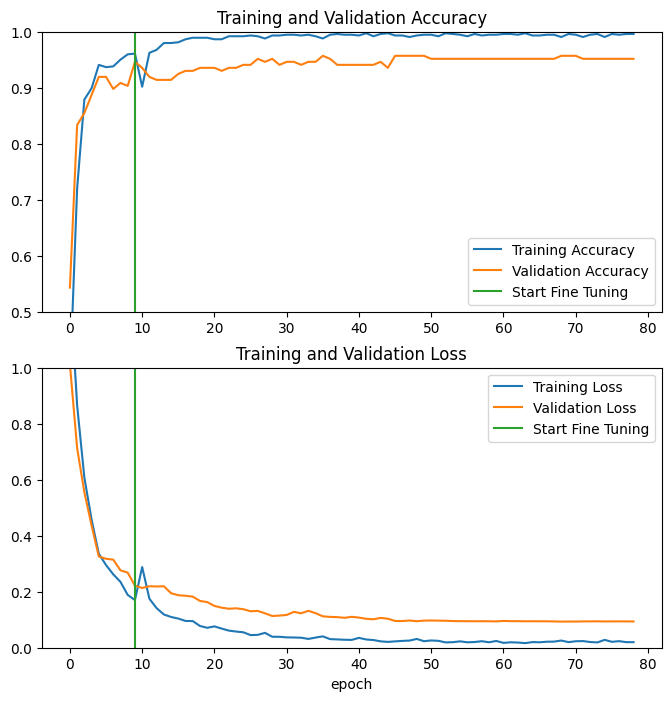

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 103ms/step - loss: 0.0933 - accuracy: 0.9570
Test accuracy : 0.9569892287254333


### 3.模型结果
使用训练好的模型对指定的图像进行预测，展示预测结果和对应的图像

1/1 [==============================] - 1s 655ms/step


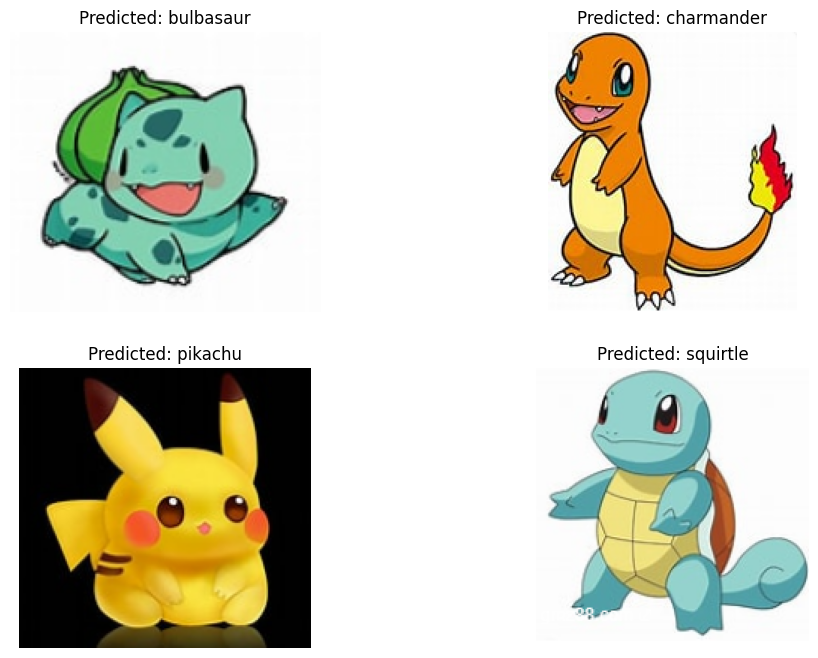

In [23]:
# 准备预测用的图像文件名
image_filenames = ['1.png', '2.png', '3.png', '4.png']

# 读取和预处理图像
images = []
for filename in image_filenames:
    img = Image.open(filename).resize((299, 299))  # 调整图像大小
    img = img.convert("RGB")  # 转换为 RGB 形式
    img = np.array(img) / 255.0  # 归一化
    images.append(img)

# 转换为 TensorFlow 的 Tensor
images = tf.convert_to_tensor(images, dtype=tf.float32)

# 使用模型进行预测
predictions = model.predict(images)

# 根据模型输出的预测结果，找到对应的类别名称
predicted_labels = [list(label_map.keys())[np.argmax(pred)] for pred in predictions]

# 展示预测结果和图像
plt.figure(figsize=(12, 8))
for i in range(len(image_filenames)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(Image.open(image_filenames[i]))
    plt.title(f'Predicted: {predicted_labels[i]}')
    plt.axis('off')

#plt.tight_layout()
plt.show()
